# Prediction of warfarin dose

## Import libraries

In [1]:
from os import sep
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.optim as optim
import pylab
import matplotlib.pyplot as plt
import math

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from model import PicsModel
from data_loader import PicsDataLoader

## Model parameters from hyperparameter optimization

In [2]:
params = {
    'hidden_neurons': 376,
    'learning_rate': 0.0017795585175007721,
    'batch': 5,
    'epochs': 17
}

## Split training with holdout

In [3]:
def split(train_dataset, validation_split):
    """ Creates a sampler to extract training and validation data
    Args:
        validation_split: decimal for the split of the validation
    """
    # random indices based off the validation split
    num_train = len(train_dataset)
    train_indices = np.array(range(num_train))
    validation_indices = np.random.choice(train_indices, int(
        num_train * validation_split), replace=False)

    train_indices = np.delete(train_indices, validation_indices)

    # subset the dataset
    train_idx, valid_idx = train_indices, validation_indices
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler

## Training

In [8]:
pics_dataloader = PicsDataLoader("data/pics_training_data_no_na.csv")
pics_dataloader_test = PicsDataLoader("data/pics_training_data_no_na_test.csv")
train_sampler, validation_sampler = split(pics_dataloader, 0.2)

train_loader = DataLoader(pics_dataloader, batch_size=params['batch'], sampler=train_sampler)
validation_loader = DataLoader(pics_dataloader, batch_size=params['batch'], sampler=validation_sampler)
test_loader = DataLoader(pics_dataloader_test, batch_size=params['batch'])

pics_model = PicsModel(params['hidden_neurons'])
criterion = nn.MSELoss()

# optimizer for model and criterion
optimizer = optim.Adam(pics_model.parameters(), lr=params['learning_rate'])

epochs = params['epochs']

In [9]:
def training():
    # iterate over the dataset multiple times
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        print('Epoch:', epoch + 1,' of ', epochs)

        # training of the model 
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # move data tensors to GPU if possible
            inputs, labels = data

            outputs = pics_model(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()
            # backpropagation by custom criterion
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        training_loss.append(running_loss / len(train_loader))
        print("Training loss: ", round(training_loss[epoch], 3))

        #validation of the model
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(validation_loader, 0):
                
                # move data tensors to GPU if possible
                inputs, labels = data
                outputs = pics_model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        validation_loss.append(running_loss / len(validation_loader))
        print("Validation loss: ", round(validation_loss[epoch], 3))

    print('Finished Training')
    
    return training_loss, validation_loss

In [10]:
def plot_loss(training_loss, validation_loss):
    pylab.plot(training_loss)
    pylab.plot(validation_loss)
    pylab.xlabel('Epochs')
    pylab.ylabel('Loss')
    pylab.legend(('Training loss', 'Validation loss'))
    pylab.title("")
    pylab.show()
    plt.savefig("results/loss_progression.png")

Epoch: 1  of  17


/home/eryk/anaconda3/envs/nsp3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss:  0.564
Validation loss:  0.516
Epoch: 2  of  17
Training loss:  0.51
Validation loss:  0.546
Epoch: 3  of  17
Training loss:  0.492
Validation loss:  0.456
Epoch: 4  of  17
Training loss:  0.487
Validation loss:  0.497
Epoch: 5  of  17
Training loss:  0.476
Validation loss:  0.456
Epoch: 6  of  17
Training loss:  0.476
Validation loss:  0.456
Epoch: 7  of  17
Training loss:  0.478
Validation loss:  0.476
Epoch: 8  of  17
Training loss:  0.472
Validation loss:  0.449
Epoch: 9  of  17
Training loss:  0.469
Validation loss:  0.448
Epoch: 10  of  17
Training loss:  0.472
Validation loss:  0.449
Epoch: 11  of  17
Training loss:  0.468
Validation loss:  0.501
Epoch: 12  of  17
Training loss:  0.467
Validation loss:  0.449
Epoch: 13  of  17
Training loss:  0.468
Validation loss:  0.447
Epoch: 14  of  17
Training loss:  0.467
Validation loss:  0.442
Epoch: 15  of  17
Training loss:  0.467
Validation loss:  0.455
Epoch: 16  of  17
Training loss:  0.467
Validation loss:  0.459
Epo

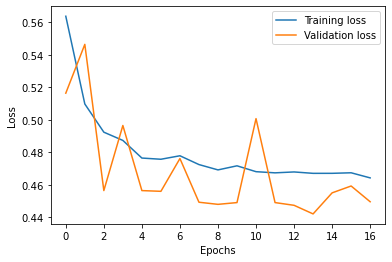

<Figure size 432x288 with 0 Axes>

In [11]:
train_l, val_l = training()

plot_loss(train_l, val_l)

## Evaluation

In [12]:
def mae(pred, labels):
    """ Returns mean absolute error
    Args:
        inputs: tensor with predicted values
        labels: tensor with correct values
    """
    err = torch.abs(labels - pred)
    return torch.mean(err).item()

In [13]:
def evaluation():
    accuracy = float()
    # iterate through the evaluation dataset

    i = 0
    with torch.no_grad():
        for data in test_loader:
            # move data tensors to GPU if possible
            inputs, labels = data
            outputs = pics_model(inputs)
            accuracy += mae(outputs, labels)
            #breakpoint()
            i+=1
        
    accuracy = accuracy / i

    print(accuracy)

In [14]:
evaluation()

0.51849799528718
